# Following the exmaple
https://github.com/pymc-devs/pymc3/blob/master/pymc3/examples/censored_data.py

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import theano.tensor as tt
import seaborn as sns
sns.set()
%matplotlib inline

Data can be left, right, or interval censored.
In this example we take interval censoring as it is the most general. In order
to deal with data censored only on one side one can simply remove one of the
sides.
Many modeling problems are of this nature, two common examples are:
- Survival analysis: at the end of a clinical trial to study the impact of a
  new drug on lifespan, it is almost never possible to follow through with the
  study until all subjects have died. At the end of the study, the only
  information known for many subjects is that a subject was still alive.
- Sensor saturation: a sensor might have a limited dynamic range and the upper
  and lower limits would simply be the lowest and highest values a sensor can
  report. An 8-bit pixel value can only hold values from 0 to 255.
This example presents two different ways of dealing with censored data in
PyMC3:
- An imputed censored model, which represents censored data as parameters and
  makes up plausible values for all censored values. This produces as a
  byproduct a plausible set of made up values that would have been censored.
  Each censored element introduces a random variable.
- An unimputed censored model, where the censored data are integrated out and
  accounted for only through the log-likelihood. This method deals more
  adequately with large amounts of censored data and converges more quickly.
To establish a baseline they compare to an uncensored model of uncensored data.

In [2]:
# Helper functions
def normal_lcdf(mu, sigma, x):
    z = (x - mu) / sigma
    return tt.switch(
        tt.lt(z, -1.0),
        tt.log(tt.erfcx(-z / tt.sqrt(2.)) / 2.) - tt.sqr(z) / 2.,
        tt.log1p(-tt.erfc(z / tt.sqrt(2.)) / 2.)
    )


def normal_lccdf(mu, sigma, x):
    z = (x - mu) / sigma
    return tt.switch(
        tt.gt(z, 1.0),
        tt.log(tt.erfcx(z / tt.sqrt(2.)) / 2.) - tt.sqr(z) / 2.,
        tt.log1p(-tt.erfc(-z / tt.sqrt(2.)) / 2.)
    )



In [3]:
# Produce normally distributed samples
np.random.seed(123)
size = 500
sigma = 5.
mu = 13.
samples = np.random.normal(mu, sigma, size)

# Set censoring limits.
high = 16.
low = -1.

# Truncate samples
truncated = samples[(samples > low) & (samples < high)]

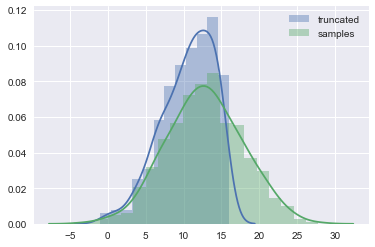

In [18]:
sns.distplot(truncated, label='truncated')
sns.distplot(samples, label='samples')

plt.legend(bbox_to_anchor=(1, 1))



In [4]:
# Omniscient model
with pm.Model() as omniscient_model:
    mu = pm.Normal('mu', mu=0., sd=(high - low) / 2.)
    sigma = pm.HalfNormal('sigma', sd=(high - low) / 2.)
    observed = pm.Normal('observed', mu=mu, sd=sigma, observed=samples)


In [5]:
# Imputed censored model
# Keep tabs on left/right censoring
n_right_censored = len(samples[samples >= high])
n_left_censored = len(samples[samples <= low])
n_observed = len(samples) - n_right_censored - n_left_censored
with pm.Model() as imputed_censored_model:
    mu = pm.Normal('mu', mu=0., sd=(high - low) / 2.)
    sigma = pm.HalfNormal('sigma', sd=(high - low) / 2.)
    right_censored = pm.Bound(pm.Normal, lower=high)(
        'right_censored', mu=mu, sd=sigma, shape=n_right_censored
    )
    left_censored = pm.Bound(pm.Normal, upper=low)(
        'left_censored', mu=mu, sd=sigma, shape=n_left_censored
    )
    observed = pm.Normal(
        'observed',
        mu=mu,
        sd=sigma,
        observed=truncated,
        shape=n_observed
    )


In [7]:
#  Unimputed censored model
def censored_right_likelihood(mu, sigma, n_right_censored, upper_bound):
    return n_right_censored * normal_lccdf(mu, sigma, upper_bound)


def censored_left_likelihood(mu, sigma, n_left_censored, lower_bound):
    return n_left_censored * normal_lcdf(mu, sigma, lower_bound)


In [8]:
with pm.Model() as unimputed_censored_model:
    mu = pm.Normal('mu', mu=0., sd=(high - low) / 2.)
    sigma = pm.HalfNormal('sigma', sd=(high - low) / 2.)
    observed = pm.Normal(
        'observed',
        mu=mu,
        sd=sigma,
        observed=truncated,
    )
    right_censored = pm.Potential(
        'right_censored',
        censored_right_likelihood(mu, sigma, n_right_censored, high)
        )
    left_censored = pm.Potential(
        'left_censored',
        censored_left_likelihood(mu, sigma, n_left_censored, low)
    )


Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...


Model with no censored data (omniscient)


Average Loss = 1,880.5:   7%|▋         | 14681/200000 [00:05<01:08, 2713.08it/s]
Convergence archived at 14700
Interrupted at 14,700 [7%]: Average Loss = 2,149.7
100%|██████████| 2000/2000 [00:03<00:00, 569.39it/s]


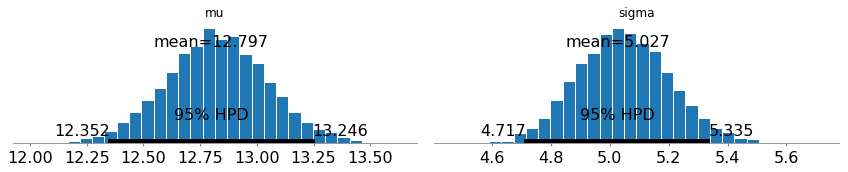

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...


Imputed censored model


Average Loss = 1,697.8:   9%|▉         | 17930/200000 [00:07<01:19, 2276.33it/s]
Convergence archived at 18000
Interrupted at 18,000 [9%]: Average Loss = 1,872.2
100%|██████████| 2000/2000 [00:18<00:00, 110.50it/s]


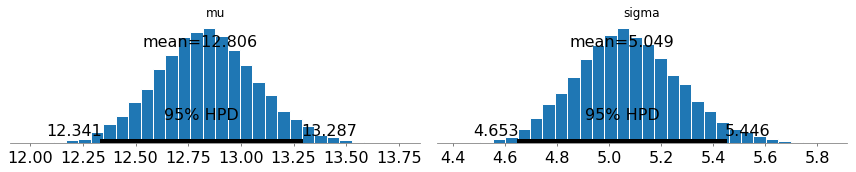

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...


Unimputed censored model


Average Loss = 1,577.9:   7%|▋         | 13823/200000 [00:06<01:23, 2217.76it/s]
Convergence archived at 13900
Interrupted at 13,900 [6%]: Average Loss = 1,818.2
100%|██████████| 2000/2000 [00:04<00:00, 419.58it/s]


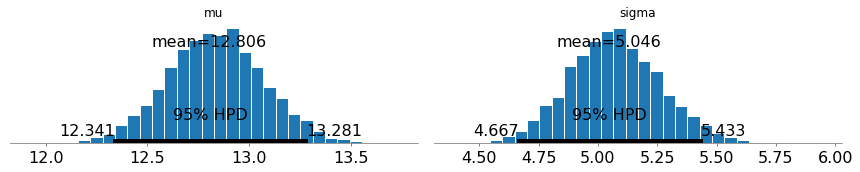

In [12]:
n=1500

if n == 'short':
    n = 50

print('Model with no censored data (omniscient)')
with omniscient_model:
    trace = pm.sample(n, njobs=8)
    pm.plot_posterior(trace[-1000:], varnames=['mu', 'sigma'])

print('Imputed censored model')
with imputed_censored_model:
    trace = pm.sample(n, njobs=8)
    pm.plot_posterior(trace[-1000:], varnames=['mu', 'sigma'])

print('Unimputed censored model')
with unimputed_censored_model:
    trace = pm.sample(n, njobs=8)
    pm.plot_posterior(trace[-1000:], varnames=['mu', 'sigma'])
